# Prediction task
***OBJECTIVES***

The aim of this exercise is to use historical data to predict the food preparation time for each order.

***STEPS***
1. Data Cleaning, exploration and visualisation on the provided data (orders.csv and restaurants.csv)
2. Build a model that estimates the time it takes for a restaurant to prepare the food for an order.
3. Evaluate the performance of this model, compare with some baseline.
4. Conclusions and further work

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm

from datetime import datetime
from matplotlib import pyplot
from statsmodels.stats import proportion

In [2]:
pyplot.rcParams['figure.figsize'] = [18, 8]
pyplot.rcParams["font.size"] = 16

Read the data

In [3]:
orders_df = pd.read_csv("orders.csv")
orders_df.order_ready_at = pd.to_datetime(orders_df.order_ready_at, utc=True)
orders_df.order_acknowledged_at = pd.to_datetime(orders_df.order_acknowledged_at, utc=True)

res_df = pd.read_csv("restaurants.csv")

In [4]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32394 entries, 0 to 32393
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_acknowledged_at  32394 non-null  datetime64[ns, UTC]
 1   order_ready_at         32394 non-null  datetime64[ns, UTC]
 2   order_value_gbp        32394 non-null  float64            
 3   restaurant_id          32394 non-null  int64              
 4   number_of_items        32394 non-null  int64              
 5   prep_time_seconds      32394 non-null  int64              
dtypes: datetime64[ns, UTC](2), float64(1), int64(3)
memory usage: 1.5 MB


In [5]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   restaurant_id  1697 non-null   int64 
 1   country        1697 non-null   object
 2   city           1697 non-null   object
 3   type_of_food   1697 non-null   object
dtypes: int64(1), object(3)
memory usage: 53.2+ KB


### BASIC DATA PREP
More data prep in feature engineering section.

In [6]:
orders_df['minute_of_the_day'] = orders_df.order_acknowledged_at.dt.hour * 60 + orders_df.order_acknowledged_at.dt.minute
orders_df['day_of_week'] = orders_df.order_acknowledged_at.dt.dayofweek
df = pd.merge(orders_df, res_df, left_on="restaurant_id", right_on='restaurant_id')

## DATA EXPLORATION

Mean preparation time: 43.33 minutes
Median preparation time: 27.33 minutes


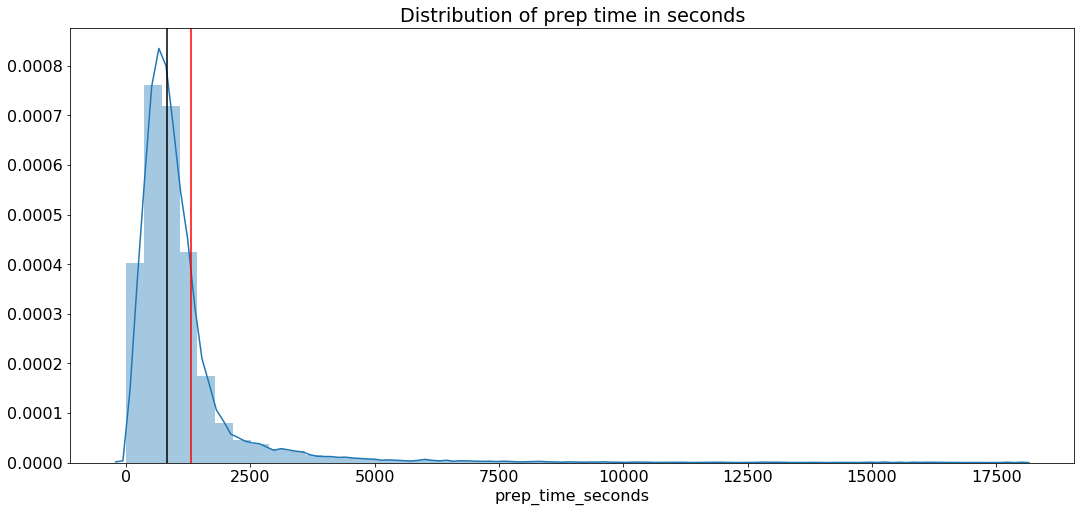

In [7]:
ax = sns.distplot(orders_df[orders_df.prep_time_seconds < 18000].prep_time_seconds) # I filter from the chart anything that took more than 5h to prepare
ax.set_title("Distribution of prep time in seconds")
mean_prep_time = np.mean(orders_df.prep_time_seconds)
median_prep_time = np.median(orders_df.prep_time_seconds)
pyplot.axvline(mean_prep_time, color ='red')
pyplot.axvline(median_prep_time, color ='black')
print("Mean preparation time: {:.2f} minutes".format(mean_prep_time/30))
print("Median preparation time: {:.2f} minutes".format(median_prep_time/30))

The median is quite shifted forward with respect of the median and of the bulk of the data. There are a large number of values that could be interpreted as outliers (for example, there are quite a few samples with prep time larger than 5h. It would be a good idea to investigate this with the business). 

#### Univariate analysis
I am going to look at how individual features relate to prep time.

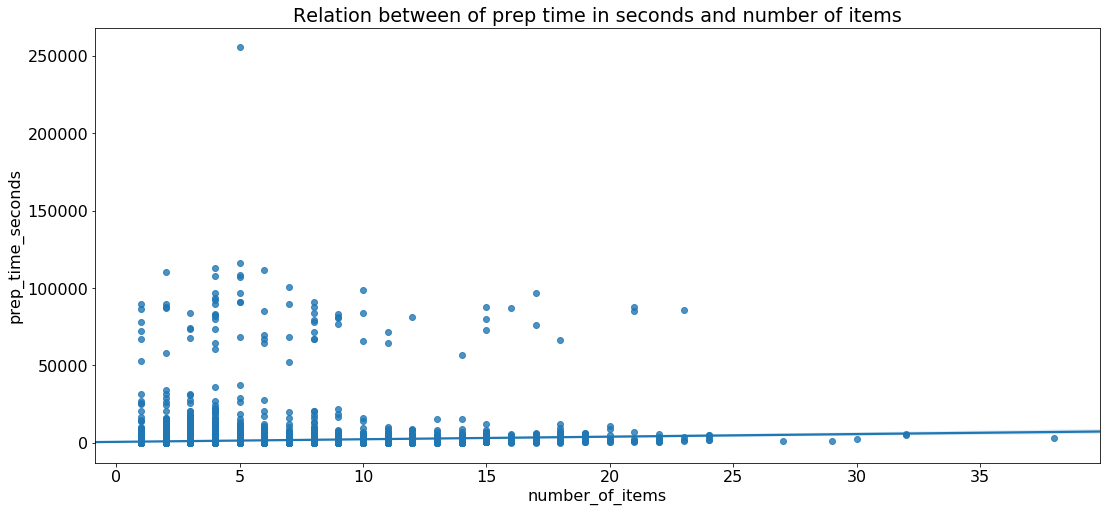

In [8]:
ax = sns.regplot(x="number_of_items", y="prep_time_seconds", data=orders_df)
_=ax.set_title("Relation between of prep time in seconds and number of items")

In [9]:
X = orders_df["number_of_items"]
y = orders_df["prep_time_seconds"]
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      prep_time_seconds   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     271.4
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           9.96e-61
Time:                        18:45:42   Log-Likelihood:            -3.1763e+05
No. Observations:               32394   AIC:                         6.353e+05
Df Residuals:                   32392   BIC:                         6.353e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             624.3099     47.709     13.086      0.000     530.798     717.822
number_of_items   167.8420     10.188     16.474      0.000     147.873     187.811
==============================================================================
Omnibus:                    73044.247   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        571307622.644
Skew:                          21.443   Prob(JB):                         0.00
Kurtosis:                     652.176   Cond. No.                         9.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From the table above we derive the following interesting observations**
 - that for each item added to the order the prep time increases by `167.8420` seconds.
 - the percentage of variance our model explains is 0.8 %, not much at all.
 - The model is statistically significant.

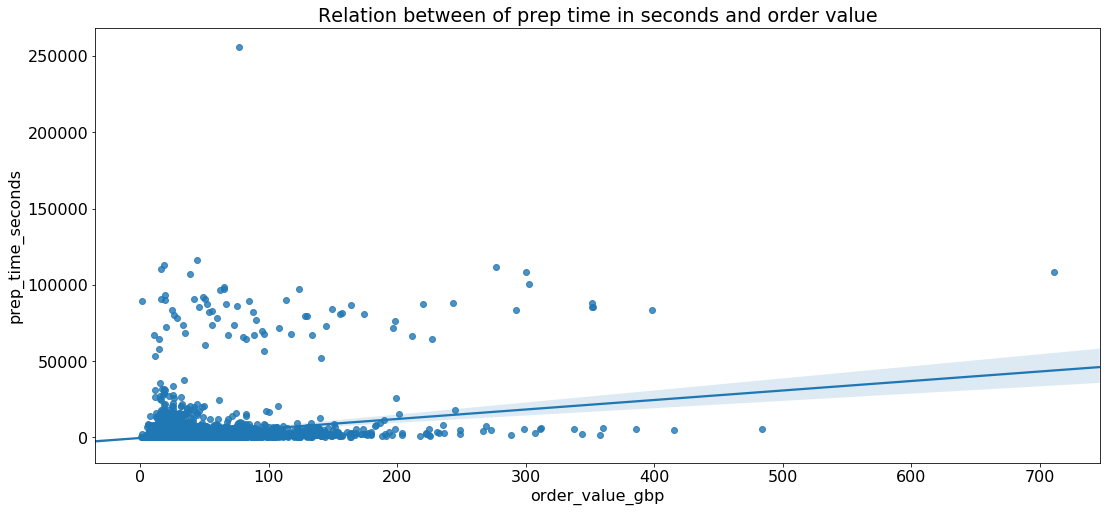

In [10]:
ax = sns.regplot(x="order_value_gbp", y="prep_time_seconds", data=orders_df)
_=ax.set_title("Relation between of prep time in seconds and order value")

In [11]:
X = orders_df["order_value_gbp"]
y = orders_df["prep_time_seconds"]
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      prep_time_seconds   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2591.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:45:46   Log-Likelihood:            -3.1652e+05
No. Observations:               32394   AIC:                         6.330e+05
Df Residuals:                   32392   BIC:                         6.331e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -351.9887     40.096     -8.779      0.000    -430.579    -273.398
order_value_gbp    62.2279      1.222     50.904      0.000      59.832      64.624
==============================================================================
Omnibus:                    71942.165   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        580252580.922
Skew:                          20.618   Prob(JB):                         0.00
Kurtosis:                     657.367   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From the table above we derive the following interesting observations**
 - that for each pound added to the order the prep time increases by `62.2279` seconds.
 - the percentage of variance our model explains is 7.4 %, better than the previous relation.
 - The model is statistically significant.

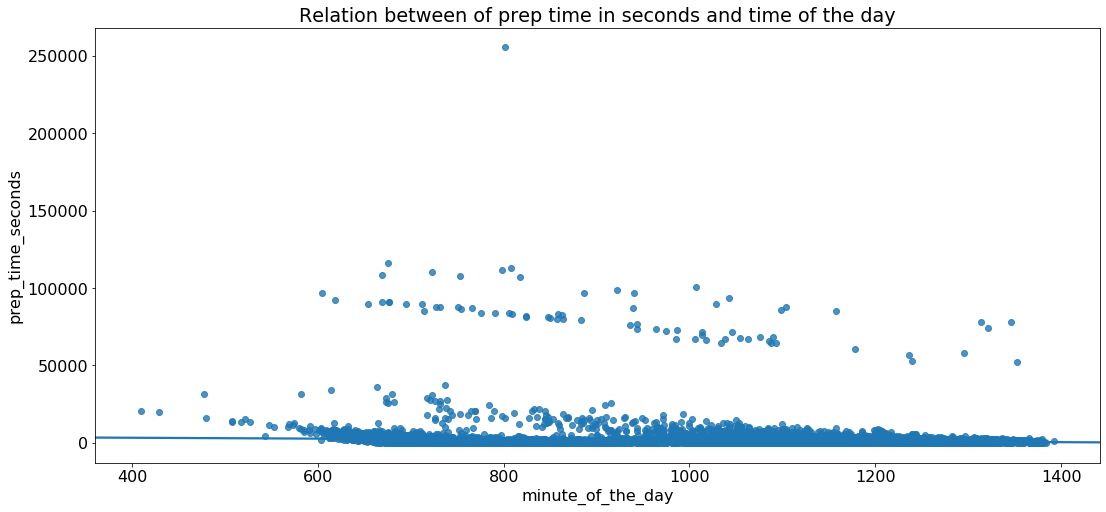

In [12]:
ax = sns.regplot(x="minute_of_the_day", y="prep_time_seconds", data=df)
_=ax.set_title("Relation between of prep time in seconds and time of the day")

In [13]:
X = orders_df["minute_of_the_day"]
y = orders_df["prep_time_seconds"]
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      prep_time_seconds   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     458.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          6.13e-101
Time:                        18:45:52   Log-Likelihood:            -3.1754e+05
No. Observations:               32394   AIC:                         6.351e+05
Df Residuals:                   32392   BIC:                         6.351e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4426.3522    148.071     29.893      0.000    4136.127    4716.578
minute_of_the_day    -2.8597      0.134    -21.404      0.000      -3.122      -2.598
==============================================================================
Omnibus:                    73102.436   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        573465218.270
Skew:                          21.485   Prob(JB):                         0.00
Kurtosis:                     653.401   Cond. No.                     6.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**From the table above we derive the following interesting observations**
 - that for each minute passed in the day the prep time decreases by `2.8597` seconds.
 - the percentage of variance our model explains is 1.4 %
 - The model is statistically significant.

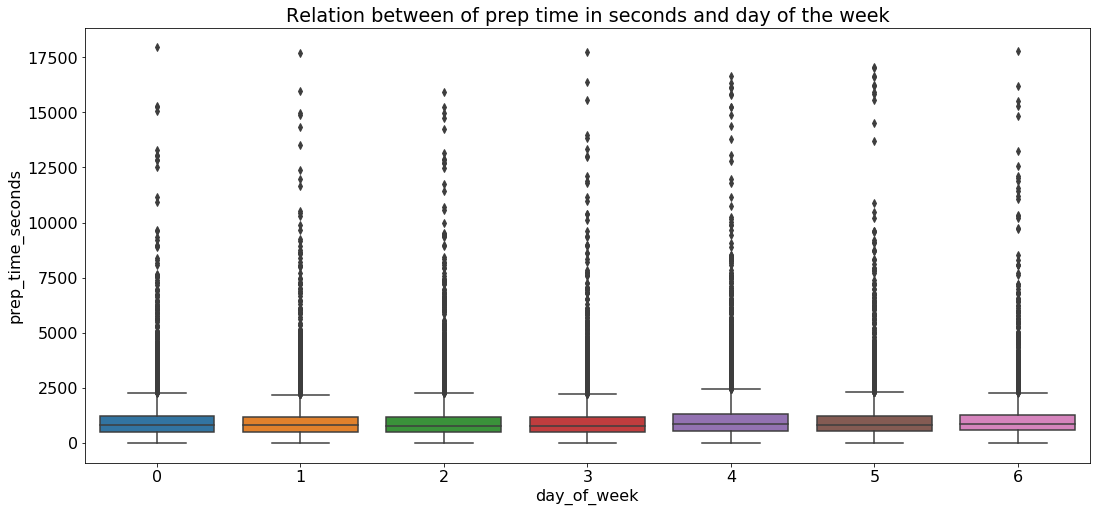

In [14]:
ax = sns.boxplot(x="day_of_week", y="prep_time_seconds", data=orders_df[orders_df.prep_time_seconds < 18000])
_=ax.set_title("Relation between of prep time in seconds and day of the week")

There is not a stron difference here. I was expecting to see a longer prep time in the weekend.

### Correlations
Let's look at how the above variables correlate to `prep_time_in_seconds`

In [15]:
df[['prep_time_seconds', 'order_value_gbp', 'number_of_items', 'minute_of_the_day']].corr().iloc[0, 1:]

order_value_gbp      0.272160
number_of_items      0.091153
minute_of_the_day   -0.118094
Name: prep_time_seconds, dtype: float64

None of them strongly correlate with the target variable.

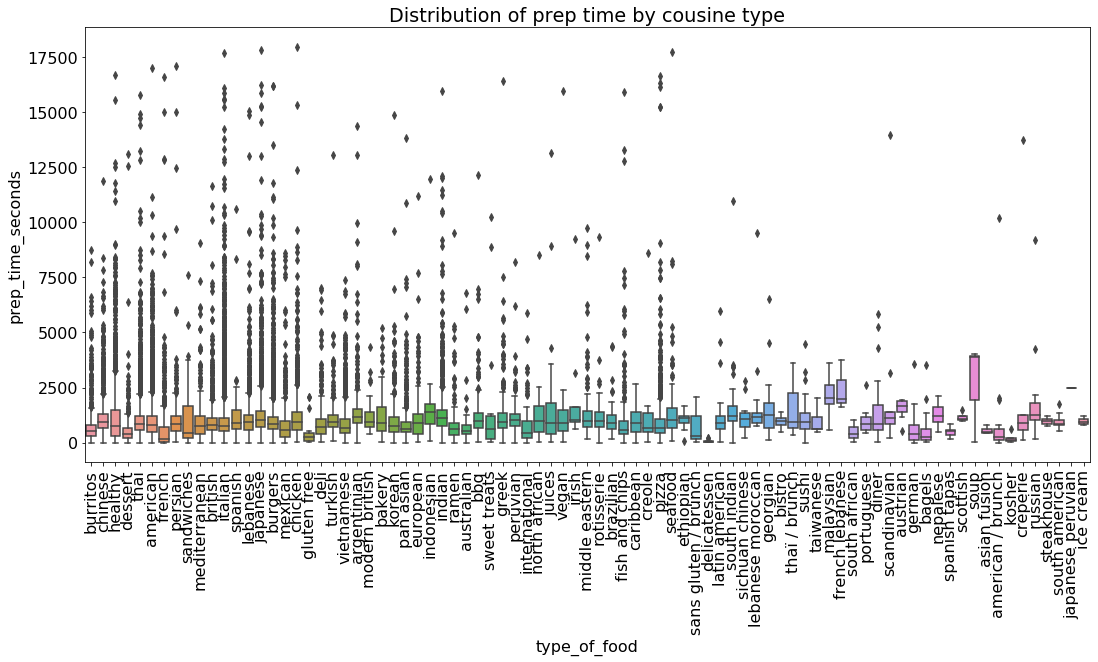

In [16]:
ax = sns.boxplot(x="type_of_food", y="prep_time_seconds", data=df[df.prep_time_seconds < 18000])
ax.set_title("Distribution of prep time by cousine type")
pyplot.xticks(rotation=90);

It looks like there are some type of food that are clearly more time demanding than others. However visual interpretation is enough to understand if there is actual difference.

I can test this hypotesis using t-tests. However the distributions do not seems to be normal therefore i will use `wilcoxon-mann-whitney` test, which do not use this assumption.
For example, let's compare `soup` and `greek` food. I will test whether the means of the two paired samples are significantly different.

Interpretation

H0: the means of the samples are equal.
H1: the means of the samples are unequal.

In [17]:
stat, p = stats.mannwhitneyu(df.loc[df.type_of_food == 'greek', 'prep_time_seconds'],df.loc[df.type_of_food == 'soup', 'prep_time_seconds'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=356.500, p=0.196
Probably the same distribution


It looks like the difference which visually appear clear is not statistically significant.

Let's look now at the prep time by city and country.

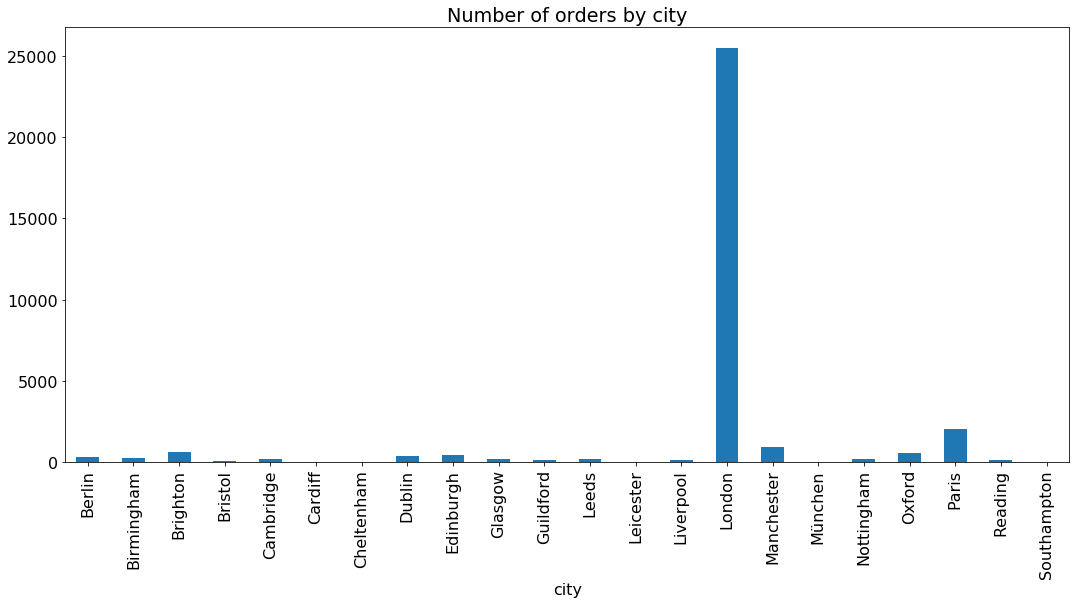

In [18]:
ax=df.groupby("city").size().plot(kind='bar')
ax.set_title("Number of orders by city");

There are cities with too few restaurant. It probably won't produce a good feature. If I had more time I would explore more this hypotesis, but give the time available I wont test it. Instead I will group by country.

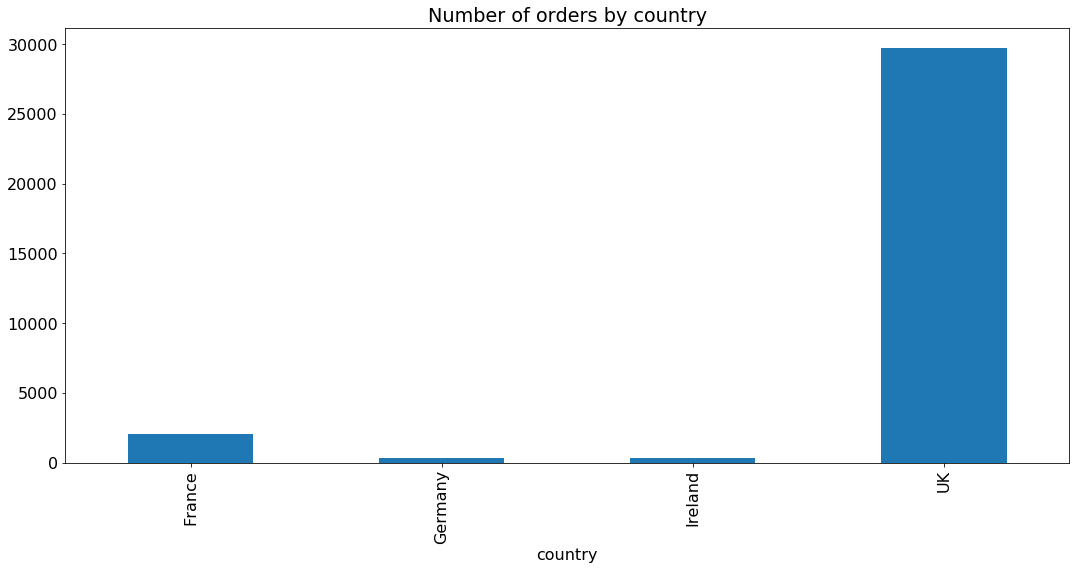

In [19]:
ax=df.groupby("country").size().plot(kind='bar')
ax.set_title("Number of orders by country");

It looks like there could be more signal with this grouping.

I am still not sure why there are prep time larger than 5 hours, I have looked a bit into it but haven't seen any good hint that could explain why this can happen. Below is just one of the charts I have created to look into the issue. If I were working on this project I would try to understand this issue, it looks like could be some data acquisition issue.

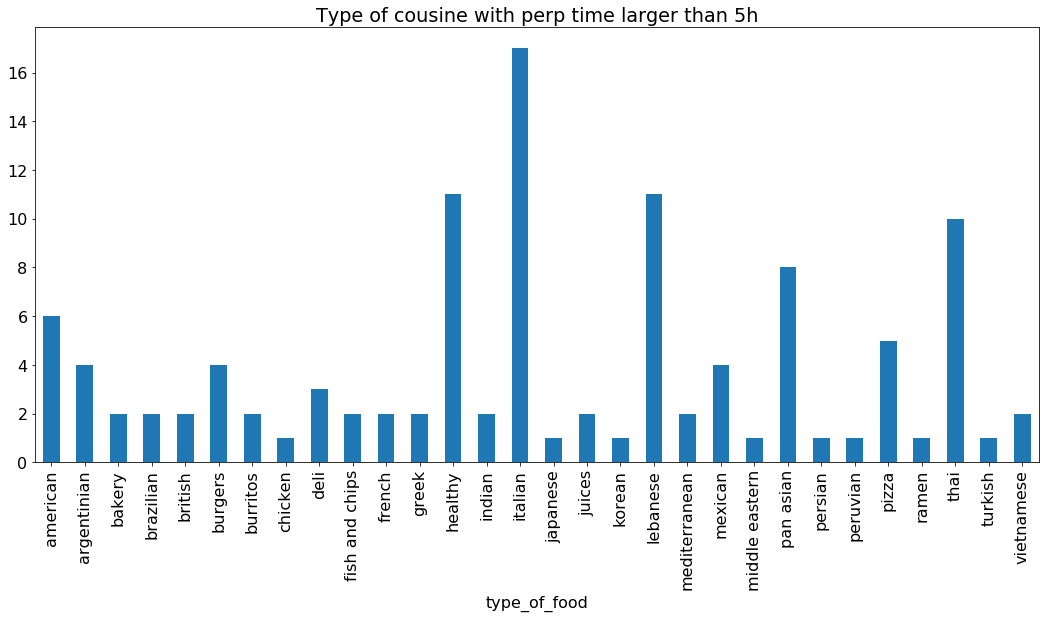

In [20]:
ax=df[df.prep_time_seconds > 18000].groupby(['type_of_food']).size().plot(kind='bar')
ax.set_title("Type of cousine with perp time larger than 5h");

there are some cousine types that have more problems than others. 

Let's look whenever the error affect only a specific restaurant

In [81]:
temp_df = df[df.prep_time_seconds > 18000].groupby(['restaurant_id']).size()
print(temp_df[temp_df > 1])
del temp_df

restaurant_id
16      2
329     2
775     2
808     2
859     2
1099    3
1181    2
1518    2
2104    2
2285    2
2733    2
2892    2
2945    3
3190    2
3242    2
3338    2
dtype: int64


No, it looks like it is more a data issue rather than a specific restaurant.

## Feature Engineering

In [21]:
df.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,minute_of_the_day,day_of_week,country,city,type_of_food
0,2015-06-01 11:28:28.952789+00:00,2015-06-01 13:12:09.474896+00:00,59.90,1326,2,6220,688,0,UK,London,burritos
1,2015-06-06 16:06:24.434807+00:00,2015-06-06 16:16:27.520253+00:00,24.00,1326,8,603,966,5,UK,London,burritos
2,2015-06-08 13:56:15.503204+00:00,2015-06-08 14:03:39.397496+00:00,15.25,1326,3,443,836,0,UK,London,burritos
3,2015-06-12 14:12:20.497925+00:00,2015-06-12 14:23:30.064683+00:00,28.05,1326,8,669,852,4,UK,London,burritos
4,2015-06-01 12:07:10.794050+00:00,2015-06-01 13:02:25.104517+00:00,56.30,255,7,3314,727,0,UK,London,chinese


I will transform minute of the day using sic and cos function. I am transforming minute of the day into sin - cosin trasformation so I can have 00:00 being next to 23:59, and therefore having a continuous version of time feature. I need both sin and cos because otherwise I would have 12am be the same than 12 pm. 

In [22]:
minute_of_the_day_norm = 2 * math.pi * df["minute_of_the_day"] / df["minute_of_the_day"].max()
df['minute_of_the_day_sin'] = np.sin(minute_of_the_day_norm)
df['minute_of_the_day_cos'] = np.cos(minute_of_the_day_norm)

I also extract the week of the year. Assumption is to try to capture possible signal for more busy seasons. If I had more time I would test this hypotesis.

In [23]:
df['week_of_the_year'] = orders_df.order_acknowledged_at.dt.week

/Users/maccheroni/.virtualenvs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


Select and dummify relevant columns. If I had more time I would create some embeddings rather than simple dummies.

In [24]:
data = df.loc[:, ['prep_time_seconds', 'order_value_gbp', 'number_of_items', 'minute_of_the_day', 'day_of_week', 'minute_of_the_day_sin', 'minute_of_the_day_cos', 'week_of_the_year']]
data = pd.concat([data, pd.get_dummies(df['country'])], axis=1)
data = pd.concat([data, pd.get_dummies(df['type_of_food'])], axis=1)

I will now have a look at correlation between features. I would drop features highly correlated. I want also to show that minute of the day is not highly correlated with the sin / cos transformation.

In [52]:
data.iloc[:, 1:8].corr()

,order_value_gbp,number_of_items,minute_of_the_day,day_of_week,minute_of_the_day_sin,minute_of_the_day_cos,week_of_the_year
order_value_gbp,1.000000,0.537032,-0.033683,-0.011038,0.057817,-0.020135,0.000056
number_of_items,0.537032,1.000000,-0.041968,0.019600,0.014943,-0.034381,0.013427
minute_of_the_day,-0.033683,-0.041968,1.000000,-0.041857,-0.299815,0.991581,0.028666
day_of_week,-0.011038,0.019600,-0.041857,1.000000,-0.018596,-0.050696,-0.142197
minute_of_the_day_sin,0.057817,0.014943,-0.299815,-0.018596,1.000000,-0.272220,0.001909
minute_of_the_day_cos,-0.020135,-0.034381,0.991581,-0.050696,-0.272220,1.000000,0.028507
week_of_the_year,0.000056,0.013427,0.028666,-0.142197,0.001909,0.028507,1.000000


It looks like that the price is farly correlated with the number of items. This is expected. However, i won't drop either of them for now. If I had more time I would defenetly try some feature selection to understand if I could boost performaces.

## MODEL BUILDING
First I will train a random forest classifier. This is mainly for two reasons: 1 - to have a baseline model on which benchmark better/more sophisticated models 2 - to look at feature importance. I will also calculate another simple baseline, where the predicting will always be the mean prep time from the data. This will allow me also to compare how good is actually is the random forest baseline.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from tpot import TPOTRegressor

In [27]:
X = data.iloc[:, 1:]
y = data['prep_time_seconds']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [57]:
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
r2s_baseline = r2_score(y_test, baseline_predictions, multioutput='variance_weighted')
print("Baseline MAE is {:.2f} seconds or {:.2f} minutes".format(mae_baseline, mae_baseline/60))
print("Baseline R2 is {}".format(r2s_baseline))

Baseline MAE is 986.34 seconds or 16.44 minutes
Baseline R2 is -2.9411213332775077e-05


MAE is 16 minutes and R^2 is a small negative value a very bad result.

In [29]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [30]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)

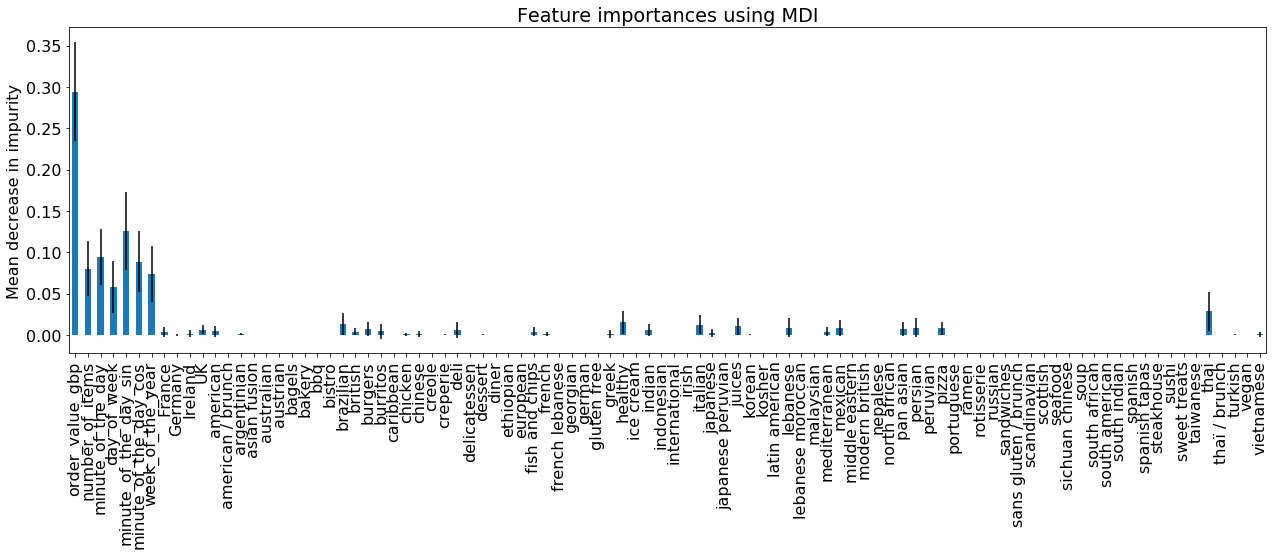

In [31]:
forest_importances = pd.Series(importances, index=data.columns[1:])

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [58]:
predictions = regr.predict(X_test)

In [60]:
rf_baseline_mae = mean_absolute_error(y_test, predictions)
rf_baseline_r2s = r2_score(y_test, predictions, multioutput='variance_weighted')

print("Mean absolute error:\nThe model has a mean error of {} seconds, roughly {:.2f} minutes \nr2 score is {}".format(rf_baseline_mae, rf_baseline_mae/60, rf_baseline_r2s))

Mean absolute error:
The model has a mean error of 937.1692706918549 seconds, roughly 15.62 minutes 
r2 score is 0.05841938622967058


I think that a mean error of 15 minutes oer order is too much. I would get a bit upset if my order was 15 minutes late than it was notified. I think we can do better than this. Also the first baseline (predicting everything as average prep time) has a MAE of 16 minuts, which isn't too far from that. So it is definetly not really good regressor.

Let's explore some more sophisticated models.

Nowadays, model selection and tuning is automated. There are many libraries or frameworks out there that can do this for you. On the cloud, sagemaker or autoML can do this at scale with large amount of data. I will use a simple library called [TPOT](http://epistasislab.github.io/tpot/). (From the website) TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for the data. Internally the score will bre generated based on a 5 fold cross validation (`cv` parameter).

In [34]:
pipeline_optimizer = TPOTRegressor(generations=150, population_size=20, cv=5,random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)


Generation 1 - Current best internal CV score: -14686315.379754653

Generation 2 - Current best internal CV score: -14686315.379754653

Generation 3 - Current best internal CV score: -14686315.379754653

Generation 4 - Current best internal CV score: -14676068.078367218

Generation 5 - Current best internal CV score: -14597687.259987185

Generation 6 - Current best internal CV score: -14597687.259987185

Generation 7 - Current best internal CV score: -14596242.071020523

Generation 8 - Current best internal CV score: -14586958.191524917

Generation 9 - Current best internal CV score: -14586958.191524917

Generation 10 - Current best internal CV score: -14571977.173410147

Generation 11 - Current best internal CV score: -14571977.173410147

Generation 12 - Current best internal CV score: -14379503.955228865

Generation 13 - Current best internal CV score: -14207092.186417112

Generation 14 - Current best internal CV score: -14207092.186417112

Generation 15 - Current best internal CV s

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=150,
              log_file=None, max_eval_time_mins=5, max_time_mins=None,
              memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=20,
              random_state=42, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

I have stopped the execution early because I left this running all night and it still didn't finish. TPOT says that the best model found so far is :

```RandomForestRegressor(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.45, min_samples_leaf=8, min_samples_split=8, n_estimators=100), bootstrap=True, max_features=0.4, min_samples_leaf=12, min_samples_split=7, n_estimators=100)```

In [46]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [48]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=8, min_samples_split=8, n_estimators=100)),
    RandomForestRegressor(bootstrap=True, max_features=0.4, min_samples_leaf=12, min_samples_split=7, n_estimators=100)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

In [49]:
exported_pipeline.fit(X_train, y_train)
tpot_predictions = exported_pipeline.predict(X_test)

In [61]:
tpot_mae = mean_absolute_error(y_test, tpot_predictions)
tpot_r2s = r2_score(y_test, tpot_predictions, multioutput='variance_weighted')

print("Mean absolute error for the stacked Randomforest-EstraTreeRegressor:\nThe model has a mean error of {} seconds, roughly {:.2f} minutes \nr2 score is {}".format(tpot_mae, tpot_mae/60, tpot_r2s))

Mean absolute error for the stacked Randomforest-EstraTreeRegressor:
The model has a mean error of 848.5335791494971 seconds, roughly 14.14 minutes 
r2 score is 0.1845268032965329


Let's summarise now the model result fond so far:

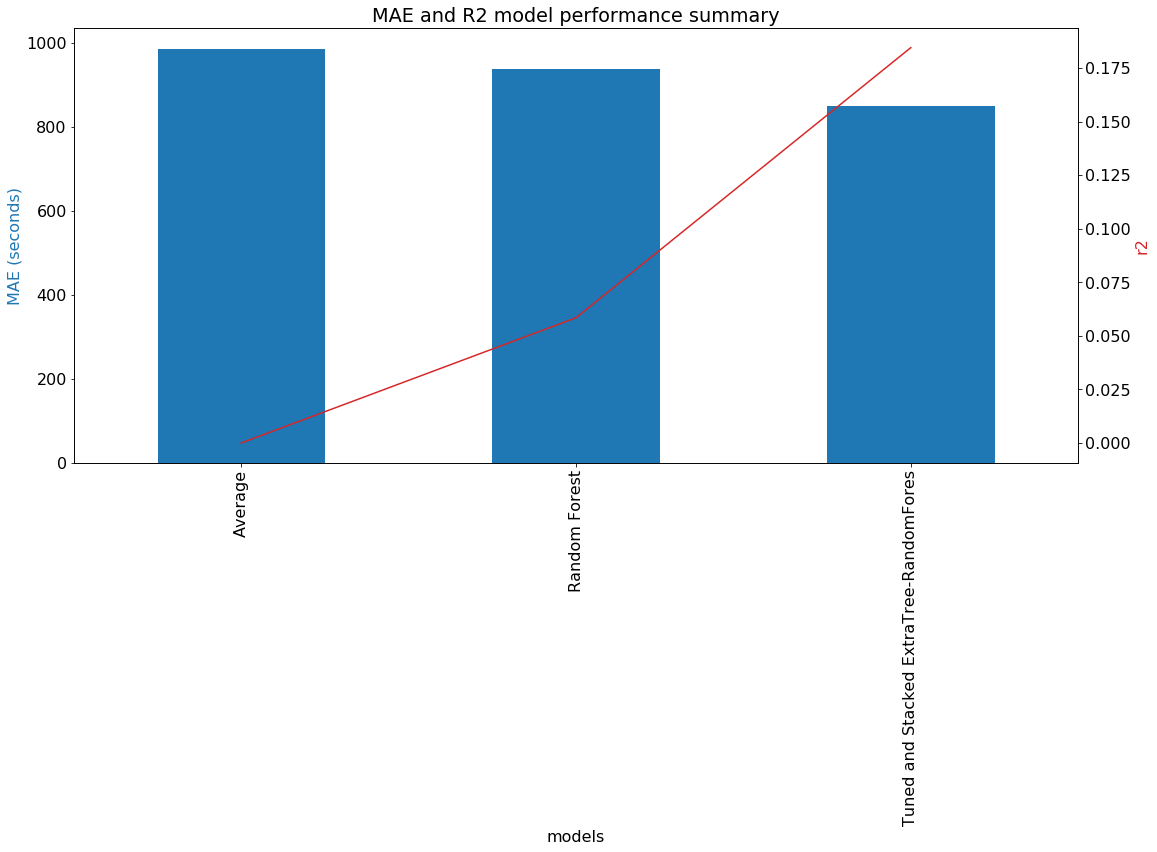

In [72]:
mae_scores = [mae_baseline, rf_baseline_mae, tpot_mae]
r2_scores = [r2s_baseline, rf_baseline_r2s, tpot_r2s]
models = ["Average", "Random Forest", "Tuned and Stacked ExtraTree-RandomFores"]
results_summary = pd.DataFrame({'mae': mae_scores, "r2": r2_scores, "models": models})
results_summary = results_summary.set_index("models")

ax=results_summary['mae'].plot(kind='bar')
ax.set_title("MAE and R2 model performance summary")
ax.set_ylabel('MAE (seconds)', color='tab:blue')  # we already handled the x-label with ax1
ax2 = ax.twinx()
ax2.set_ylabel('r2', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(results_summary.index, results_summary['r2'], color='tab:red');

MAE is very sensitive to outliers, for this reason I also plotted the R^2. I like MAE as metric because it mantain the unit of mesure of the target variable and for this reason it is easy to interpret. 

Note:
 - TPOT when tunig tries multiple optimisation metrics. 
 - Best possible R^2 score is 1.0 and it can be negative (because the model can be arbitrarily worse).

### Model analysis
I will check how well calibrated the model is and how it performs on what for me appear  outlier values.

In [73]:
calibration_df = pd.DataFrame({"predictions": tpot_predictions, "actuals": y_test})
calibration_df['residuals'] = abs(calibration_df.predictions - calibration_df.actuals)
calibration_df['bins'] = pd.cut(calibration_df.actuals, 10)

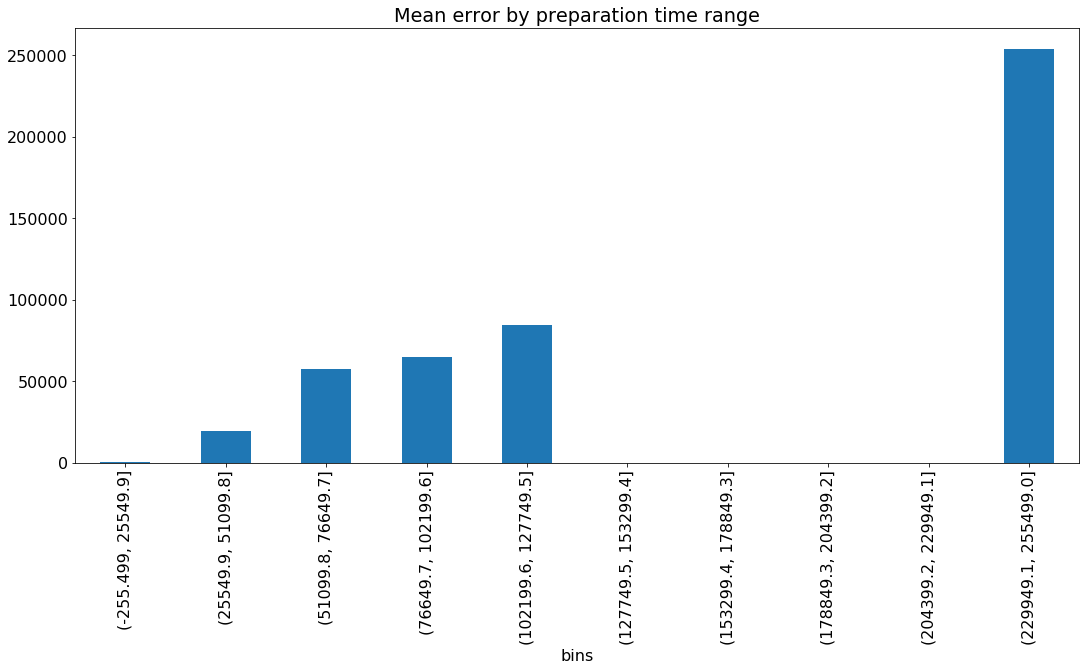

In [74]:
ax=calibration_df.groupby('bins')['residuals'].mean().fillna(0).plot(kind='bar')
ax.set_title("Mean error by preparation time range");

It is clear that the model gets quite bad at predicting very large preparation times. It is ureasonable from a business prespective to have preparation time larger than a few hours. I believe this could be a data acquisition error or something like that. 

In [83]:
temp_df = calibration_df[calibration_df.actuals < 7200] # Just get prep times less than 2 h
mae = mean_absolute_error(temp_df.actuals, temp_df.predictions)
del temp_df
print("Mean absolute error:\nThe model has a mean error of {} seconds, roughly {:.2f} minutes".format(mae, mae/60))

Mean absolute error:
The model has a mean error of 589.0259131708352 seconds, roughly 9.82 minutes


Error goes down quite a bit if we do not consider preparation times larger than 2 hours in the data, on the same set of predictions. We could then either focus on fixing the acquisition problem or even thinking to build a separate proces for resutaurants that do delayed/very long delivery times.

### CONCLUSIONS
The data appear to present some data acquisitions problem. There are some data points that to me appear as clear outliers, data points with preparation times more than one hour. Other than that the data is quite good with no missing or dirty data. The frist strong suggestion will be to tackle this issue. However, building a model on the entire data produce an average error of about 14 minutes. Which is quite a lot. The baseline is around 15-16 minutes. But from an user prespective this is still quite high. However, if I exclude from the data the outliers the average error go down to between 9-10 minutes. Focusing on this shows the most promising area of intervention. MAE is quite sensitive to outliers and for that reason I also looked at R^2 as metric. With more time I would tune more the model and maybe exclude outliers from the data.

### FUTURE WORK
If I had more time I would try the following:
 - Link external data sources such as temperature at the time of order acknowledge and check if that could have an impact
 - Group by city rather than country and see if that could change performances. I believe there is more signal in groupings with more data, hence I grouped by country in this version.
 - Test all the other assumption made on the data.
 - Understand why some orders take more than 5h to prepare
 - Try feature selection (for example, price is fairly correlated with number of items).
 - Use embeddings rather than dummies
 - Use lager population size and number of generations for better model tuning in TPOT
 - Build a new model excluding from training data data points with preparation time greater let's say than 2 hours, and assess performances.